In [ ]:
# ! uv add jupyterlab ipykernel scikit-learn==1.4.2 imbalanced-learn==0.12.3 pandas matplotlib seaborn lightgbm 

### Import 

In [ ]:
import pickle
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configure Pandas to display each DataFrame row in one line without wrapping
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Load Data

In [3]:
df_1 = pd.read_csv('data/processed_wallet_data_1.csv')
df_56 = pd.read_csv('data/processed_wallet_data_56.csv')
df_137= pd.read_csv('data/processed_wallet_data_137.csv')
df_1.shape, df_56.shape, df_137.shape

((29432, 1049), (29432, 988), (29432, 965))

In [5]:
df_1.columns

Index(['address', 'mapped_label', '0x000000000077ee1fcfe351df1ff22736e995806b',
       '0x0000000000a39bb272e79075ade125fd351887ac',
       '0x00000000a6dcb65cff59202b627b628c288769d7',
       '0x009a42e3bc21edebeab67151deda7538e2c5cc97',
       '0x009e864923b49263c7f10d19b7f8ab7a9a5aad33',
       '0x0164c1b65f89b0e201ecfd61b829f5e07172fd40',
       '0x0176b898e92e814c06cc379e508ceb571f70bd40',
       '0x01db89aec452d1628ddc364ff8ae6dde41f3972a',
       ...
       '17', '18', '19', '20', '21', '22', '23', 'balance', 'total_tx',
       'mean_transaction_usd'],
      dtype='object', length=1049)

In [6]:
df_1['mapped_label'].value_counts()

mapped_label
southern_asia     8987
southeast_asia    7578
europe            6785
africa            2474
america           1837
western_asia      1771
Name: count, dtype: int64

In [4]:
def rename_columns(df, chain_id):
    new_hours_columns = {
        str(hour): f"{hour}_{chain_id}" for hour in range(24)
    }
    new_transaction_columns = {
        "balance" : f"balance_{chain_id}",
        "total_tx" : f"total_tx_{chain_id}",
        "mean_transaction_usd" : f"mean_transaction_usd_{chain_id}",
    }
    df.rename(columns={**new_hours_columns, **new_transaction_columns}, inplace=True)
    return df
df_1 = rename_columns(df_1, 1)
df_56 = rename_columns(df_56, 56)
df_137 = rename_columns(df_137, 137)

In [5]:
df_temp1 = df_1.merge(df_56, on=['address', 'mapped_label'], how='outer')
df_temp2 = df_temp1.merge(df_137, on=['address', 'mapped_label'], how='outer')


In [6]:
df = df_temp2.copy()
df.drop(columns=['address'], inplace=True)


### Split Data

In [7]:
X = df.drop('mapped_label', axis=1)  
y = df['mapped_label']              
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1,  
    random_state=13, 
    stratify=y
)


print("Kích thước tập dữ liệu gốc:", X.shape, y.shape)
print("Kích thước tập huấn luyện (train):", X_train.shape, y_train.shape)
print("Kích thước tập kiểm thử (test):", X_test.shape, y_test.shape)

print("\nPhân bổ nhãn trong tập gốc:\n", df['mapped_label'].value_counts(normalize=True))
print("\nPhân bổ nhãn trong tập train:\n", y_train.value_counts(normalize=True))
print("\nPhân bổ nhãn trong tập test:\n", y_test.value_counts(normalize=True))

Kích thước tập dữ liệu gốc: (29432, 2996) (29432,)
Kích thước tập huấn luyện (train): (26488, 2996) (26488,)
Kích thước tập kiểm thử (test): (2944, 2996) (2944,)

Phân bổ nhãn trong tập gốc:
 mapped_label
southern_asia     0.305348
southeast_asia    0.257475
europe            0.230531
africa            0.084058
america           0.062415
western_asia      0.060173
Name: proportion, dtype: float64

Phân bổ nhãn trong tập train:
 mapped_label
southern_asia     0.305346
southeast_asia    0.257475
europe            0.230519
africa            0.084076
america           0.062406
western_asia      0.060178
Name: proportion, dtype: float64

Phân bổ nhãn trong tập test:
 mapped_label
southern_asia     0.305367
southeast_asia    0.257473
europe            0.230639
africa            0.083899
america           0.062500
western_asia      0.060122
Name: proportion, dtype: float64


### EDA

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29432 entries, 0 to 29431
Columns: 2997 entries, mapped_label to mean_transaction_usd_137
dtypes: float64(79), int64(2917), object(1)
memory usage: 673.0+ MB


In [13]:
sns.set_palette("pastel")

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_distribution(column, test=False, log_scale=False):
    plt.figure(figsize=(8, 5))
    if log_scale:
        sns.kdeplot(
            np.log1p(X_train[column]), label="Train", linewidth=2, fill=True, alpha=0.3
        )
        if test:
            sns.kdeplot(np.log1p(X_test[column]),label="Test",linewidth=2,fill=True,alpha=0.3,
            )

    else:
        sns.kdeplot(X_train[column], label="Train", linewidth=2, fill=True, alpha=0.3)
        if test:
            sns.kdeplot(
                X_test["balance"], label="Test", linewidth=2, fill=True, alpha=0.3
            )
    plt.xlabel(f"log(1 + {column})" if log_scale else f"{column}")
    plt.ylabel("Density")
    plt.title(
        "Log-Scaled Distribution of {column}"
        if log_scale
        else f"Distribution of {column}"
    )
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

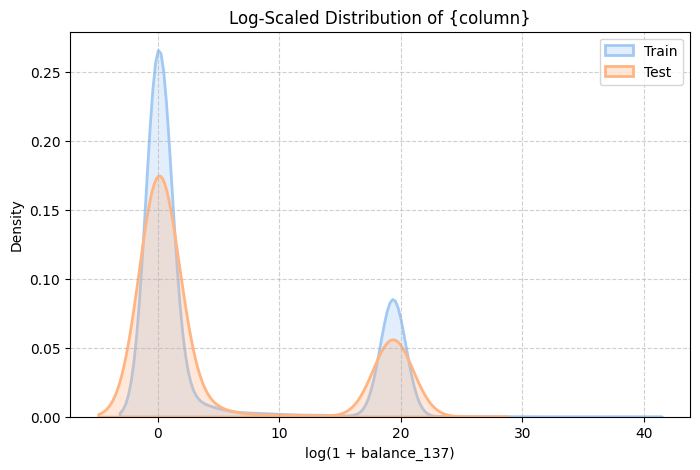

In [ ]:
plot_distribution("balance_1", test=True, log_scale=True)
#plot_distribution("balance_137", test=True, log_scale=True)
#plot_distribution("balance_56", test=True, log_scale=True)

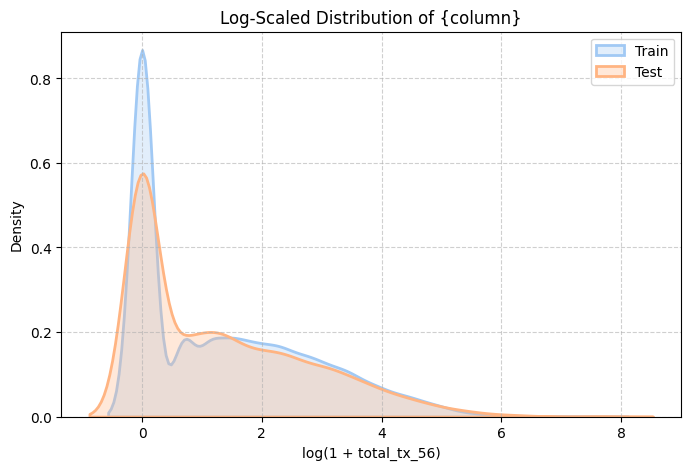

In [ ]:
#plot_distribution("total_tx_1", test=True, log_scale=True)
#plot_distribution("total_tx_137", test=True, log_scale=True)
#plot_distribution("total_tx_56", test=True, log_scale=True)

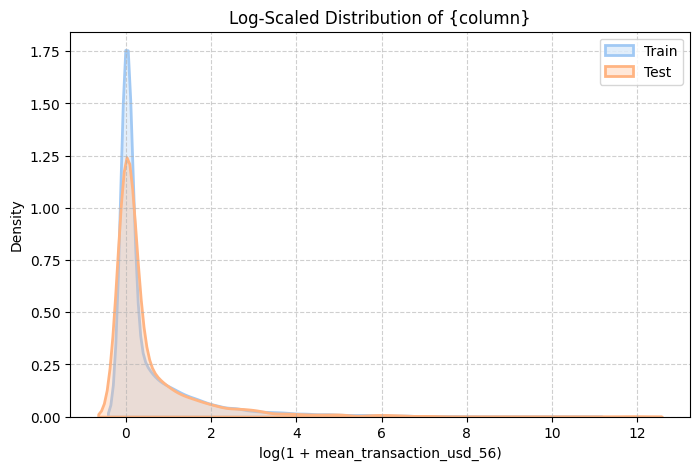

In [ ]:
#plot_distribution("mean_transaction_usd_1", test=True, log_scale=True)
#plot_distribution("mean_transaction_usd_137", test=True, log_scale=True)
#plot_distribution("mean_transaction_usd_56", test=True, log_scale=True)

Distribution of label

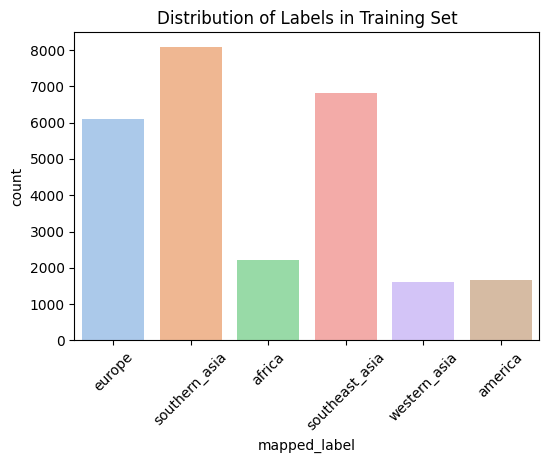

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train, palette="pastel")
plt.title("Distribution of Labels in Training Set")
plt.xticks(rotation=45)
plt.show()

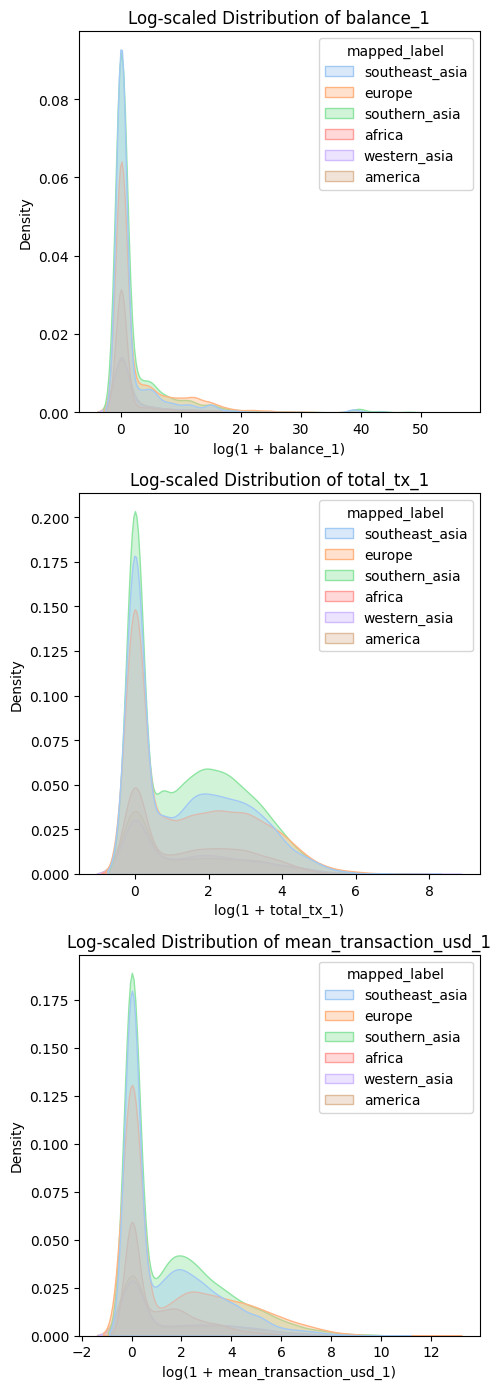

In [29]:
df_log = df.copy()
for col in ["balance_1", "total_tx_1", "mean_transaction_usd_1"]:
    df_log[col] = np.log1p(df_log[col])

# Set pastel color palette
sns.set_palette("pastel")

# Numerical features comparison
num_features = ["balance_1", "total_tx_1", "mean_transaction_usd_1"]
fig, axes = plt.subplots(3,1, figsize=(5,14))

for i, col in enumerate(num_features):
    sns.kdeplot(data=df_log, x=col, hue="mapped_label", fill=True, ax=axes[i], alpha=0.4)
    axes[i].set_title(f"Log-scaled Distribution of {col}")
    axes[i].set_xlabel(f"log(1 + {col})")

plt.tight_layout()
plt.show()


In [16]:
# # 1. Tạo danh sách các cột thời gian (từ '0' đến '23')
# time_cols = [str(i) for i in range(24)]

# # 2. Gom nhóm theo 'label', chọn các cột thời gian và tính giá trị trung bình
# time_stats_by_label = df.groupby('label')[time_cols].mean()

# # 3. Sử dụng .T (Transpose) để hoán vị bảng, giúp dễ so sánh hơn
# # Giờ đây mỗi hàng là một khung giờ, mỗi cột là một khu vực
# comparison_table = time_stats_by_label.T

# # In kết quả
# print("Bảng thống kê số lượng giao dịch TRUNG BÌNH mỗi giờ theo từng khu vực:")
# print(comparison_table)

## Train Model

### Add Featuue

In [8]:
def transformX(X: pd.DataFrame):
    X_transformed = X.copy()
    X_transformed['sum_balance'] = X_transformed['balance_1'] + X_transformed['balance_137'] + X_transformed['balance_56']
    X_transformed['sum_tx'] = X_transformed['total_tx_1'] + X_transformed['total_tx_137'] + X_transformed['total_tx_56']
    for chain_id in [1,56,137]:
        hour_columns = [f"{i}_{chain_id}" for i in range(24)]
        X_transformed[f"time_std_{chain_id}"] = X_transformed[hour_columns].std(axis=1)
        X_transformed[f'peak_hour_{chain_id}'] = (
            X_transformed[hour_columns].idxmax(axis=1)
            .str.extract(r"^(\d+)_")[0]  # lấy phần số giờ trước dấu _
            .astype(float)               # chuyển thành số (có thể là int nếu bạn muốn)
        )

        X_transformed[f'total_txn{chain_id}'] = X_transformed[hour_columns].sum(axis=1)
        X_transformed[f'active_hours_{chain_id}'] = (X_transformed[hour_columns] > 0).sum(axis=1)
    
    return X_transformed
X_train = transformX(X_train)
X_test = transformX(X_test)

### Data

In [8]:

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (26488, 2996)
y_train shape: (26488,)
X_test shape: (2944, 2996)
y_test shape: (2944,)


### SMOTE 
not good

In [ ]:
# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(f"After resampling: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

After resampling: X_train shape: (48528, 3010), y_train shape: (48528,)


In [10]:
def eval(model, on_train=False):
    if on_train:
        X_eval, y_eval = X_train, y_train
    else:
        X_eval, y_eval = X_test, y_test

    y_pred = model.predict(X_eval)

    
    class_names = sorted(np.unique(y_eval).astype(str).tolist())

    print("Báo cáo Phân loại (Classification Report):")
    print(classification_report(y_eval, y_pred, target_names=class_names))

    print("\nĐang tạo Ma trận Nhầm lẫn...")
    cm = confusion_matrix(y_eval, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Ma trận Nhầm lẫn (Confusion Matrix)', fontsize=15, weight='bold')
    plt.ylabel('Nhãn Thật (True Label)', fontsize=12)
    plt.xlabel('Nhãn Dự đoán (Predicted Label)', fontsize=12)
    plt.savefig('confusion_matrix.png')
    print("Đã vẽ và lưu Ma trận Nhầm lẫn vào file 'confusion_matrix.png'")
    plt.show()


In [10]:
best_lgbm_params = {
    "learning_rate": 0.1,
    "max_depth": 7,
    "min_child_samples": 50,
    "n_estimators": 200,
    "num_leaves": 31,
    'reg_alpha': 0.1,
    'reg_lambda': 0.01
}

In [ ]:
# from lightgbm import LGBMClassifier
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# param_grid = {
#     'n_estimators': [200],
#     'learning_rate': [0.05, 0.1],
#     'num_leaves': [31],
#     'reg_alpha' : [0.01,0.1],
#     'reg_lambda': [0.01, 0.1]
#     #'min_child_samples': [20, 50],
#     # 'max_depth': [5, 7, 10],
#     # subsample': [0.8, 1.0]  
    
# }

# lgbm = LGBMClassifier(random_state=42, **best_lgbm_params)


# search = HalvingGridSearchCV(
#     estimator=lgbm,

#     cv=5,
#     param_grid=param_grid,

#     scoring='f1_macro',

#     random_state=42,

#     verbose=3,

#     n_jobs=-1,
# )


# search.fit(X_train, y_train)


# best_lgbm = search.best_estimator_

# print("Best parameters found: ", search.best_params_)


# final_score = best_lgbm.score(X_test, y_test)

# print(f"Final score on test set(acc): {final_score:.4f}")

In [9]:

best_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)
best_lgbm.fit(X_train, y_train)
eval(best_lgbm)

NameError: name 'best_lgbm_params' is not defined

# VALID SET

In [11]:
# Tách một phần nhỏ từ tập train ra làm tập validation
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,  
    random_state=13, 
    stratify=y_train
)
best_lgbm_val_params = {
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_samples": 100,
    "num_leaves": 31,
    'reg_alpha': 0.1,
    'reg_lambda': 0.01
}
# Khởi tạo mô hình với n_estimators lớn
best_lgbm_val = LGBMClassifier(**best_lgbm_val_params, n_estimators=1000, random_state=42, is_unbalance = True)

# Huấn luyện với early stopping
best_lgbm_val.fit(
    X_train_part, y_train_part,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_error', 
    callbacks=[lgb.early_stopping(100, verbose=True)] # Dừng nếu sau 100 vòng không cải thiện
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9362
[LightGBM] [Info] Number of data points in the train set: 21190, number of used features: 2076
[LightGBM] [Info] Start training from score -2.475793
[LightGBM] [Info] Start training from score -2.774384
[LightGBM] [Info] Start training from score -1.467360
[LightGBM] [Info] Start training from score -1.356813
[LightGBM] [Info] Start training from score -1.186353
[LightGBM] [Info] Start training from score -2.810583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=5,
               min_child_samples=100, n_estimators=1000, random_state=42,
               reg_alpha=0.1, reg_lambda=0.01)

In [12]:
import matplotlib.pyplot as plt

Báo cáo Phân loại (Classification Report):
                precision    recall  f1-score   support

        africa       0.74      0.58      0.65       247
       america       0.65      0.22      0.33       184
        europe       0.55      0.70      0.62       679
southeast_asia       0.60      0.63      0.62       758
 southern_asia       0.62      0.70      0.66       899
  western_asia       0.57      0.11      0.19       177

      accuracy                           0.60      2944
     macro avg       0.62      0.49      0.51      2944
  weighted avg       0.61      0.60      0.59      2944


Đang tạo Ma trận Nhầm lẫn...
Đã vẽ và lưu Ma trận Nhầm lẫn vào file 'confusion_matrix.png'


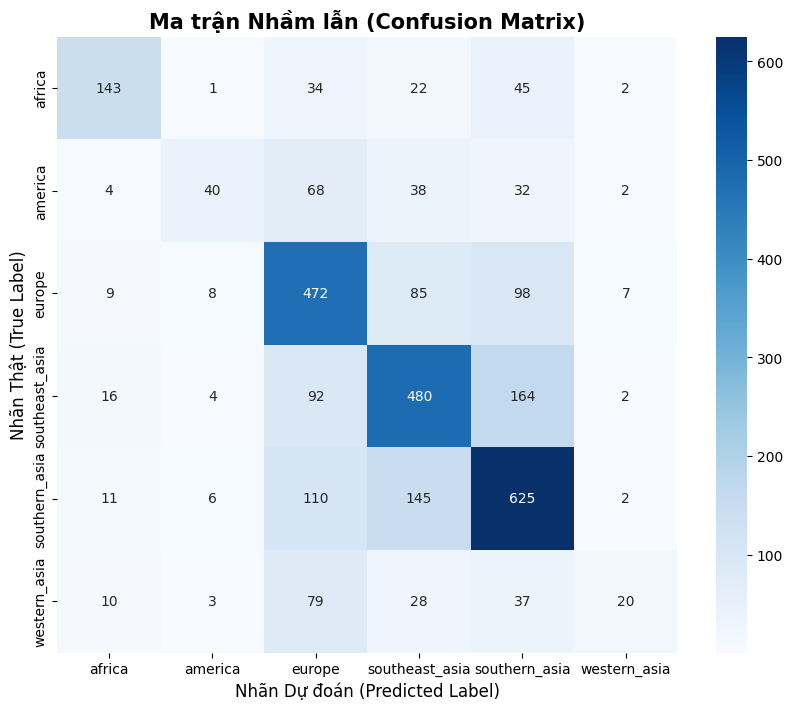

In [13]:
eval(best_lgbm_val, on_train=False)

Báo cáo Phân loại (Classification Report):
                precision    recall  f1-score   support

        africa       0.88      0.88      0.88      8088
       america       0.80      0.92      0.85      8088
        europe       0.85      0.80      0.82      8088
southeast_asia       0.88      0.80      0.84      8088
 southern_asia       0.89      0.85      0.87      8088
  western_asia       0.85      0.88      0.86      8088

      accuracy                           0.86     48528
     macro avg       0.86      0.86      0.86     48528
  weighted avg       0.86      0.86      0.86     48528


Đang tạo Ma trận Nhầm lẫn...
Đã vẽ và lưu Ma trận Nhầm lẫn vào file 'confusion_matrix.png'


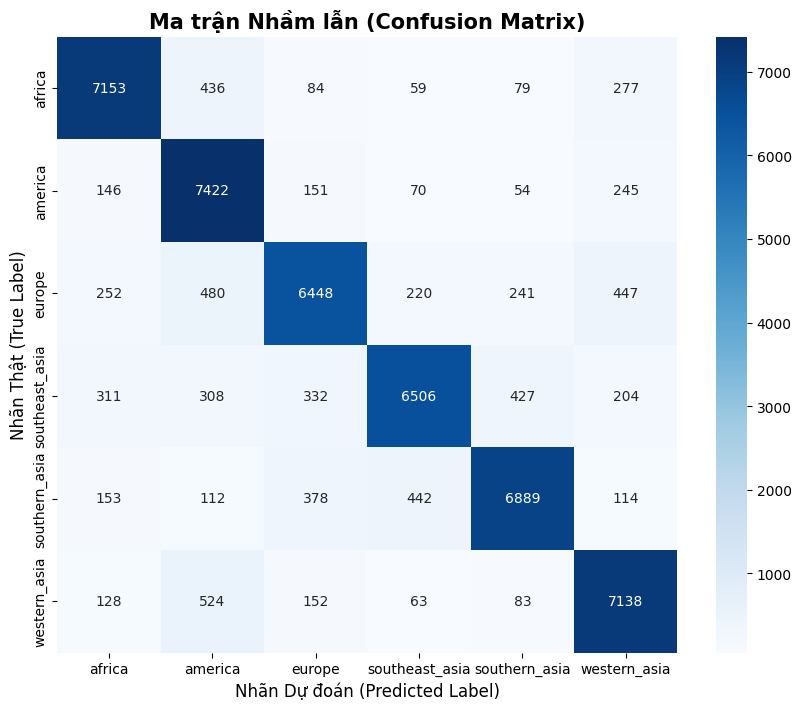

In [43]:
eval(best_lgbm_val, on_train=True)

# No valid set

Báo cáo Phân loại (Classification Report):
                precision    recall  f1-score   support

        africa       0.49      0.55      0.52       247
       america       0.31      0.29      0.30       184
        europe       0.58      0.70      0.63       679
southeast_asia       0.64      0.57      0.60       758
 southern_asia       0.65      0.63      0.64       899
  western_asia       0.28      0.20      0.24       177

      accuracy                           0.58      2944
     macro avg       0.49      0.49      0.49      2944
  weighted avg       0.57      0.58      0.57      2944


Đang tạo Ma trận Nhầm lẫn...
Đã vẽ và lưu Ma trận Nhầm lẫn vào file 'confusion_matrix.png'


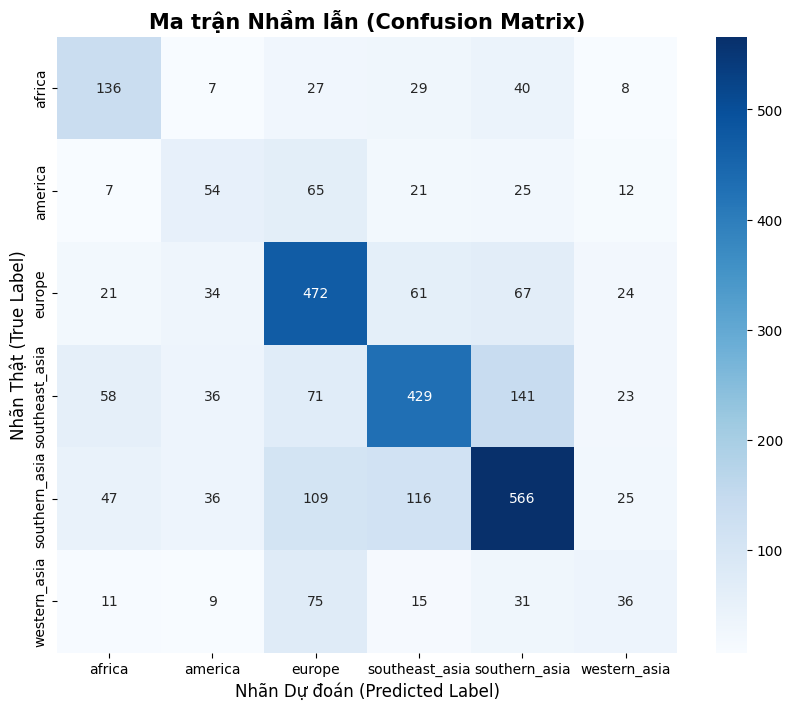

In [ ]:
#eval(best_lgbm, on_train=False)

Báo cáo Phân loại (Classification Report):
                precision    recall  f1-score   support

        africa       0.72      0.84      0.78      8088
       america       0.76      0.82      0.79      8088
        europe       0.79      0.71      0.75      8088
southeast_asia       0.86      0.73      0.79      8088
 southern_asia       0.85      0.80      0.82      8088
  western_asia       0.74      0.80      0.77      8088

      accuracy                           0.78     48528
     macro avg       0.79      0.78      0.78     48528
  weighted avg       0.79      0.78      0.78     48528


Đang tạo Ma trận Nhầm lẫn...
Đã vẽ và lưu Ma trận Nhầm lẫn vào file 'confusion_matrix.png'


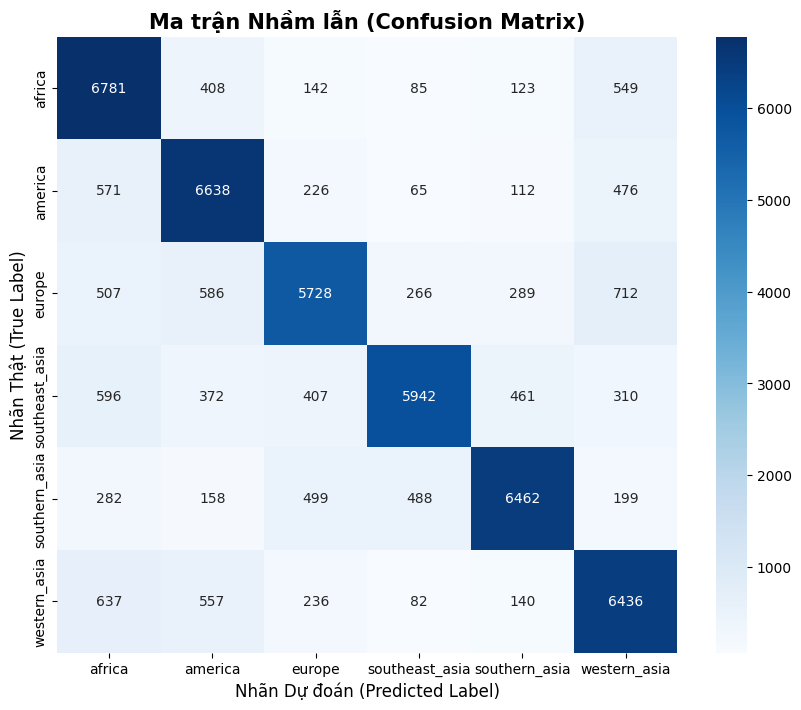

In [ ]:
#eval(best_lgbm, on_train=True)

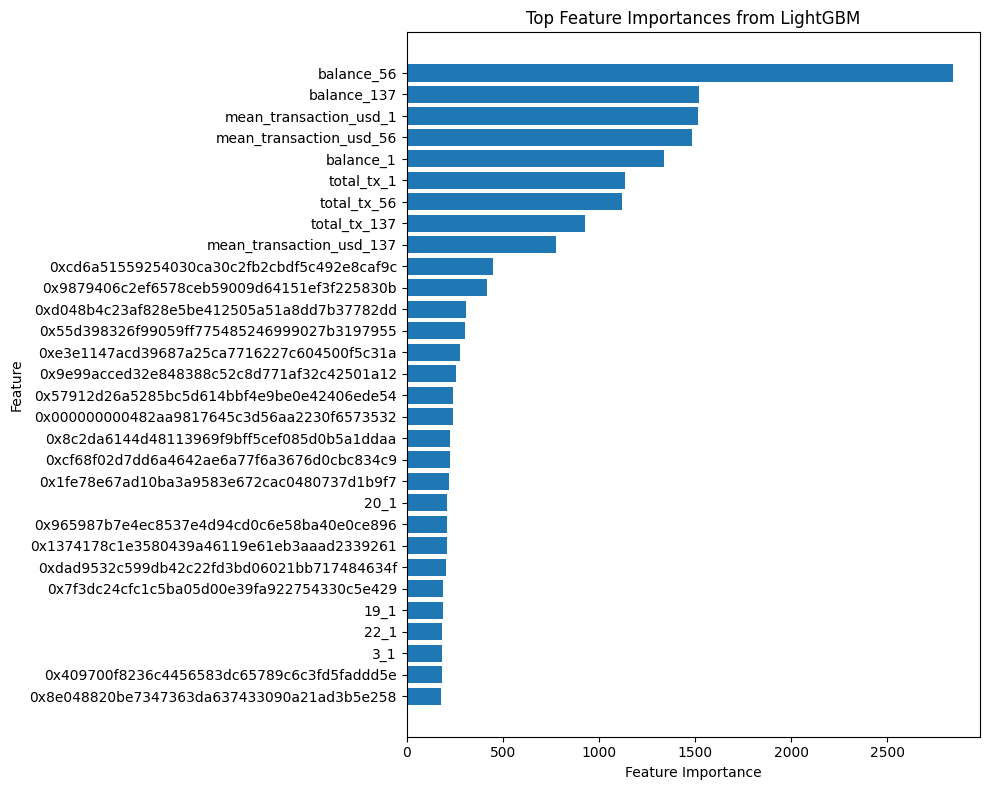

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn có mô hình best_lgbm_val đã được huấn luyện
# Lấy danh sách tên cột (features) và độ quan trọng
feature_importance = pd.DataFrame({
    'feature': best_lgbm_val.feature_name_,
    'importance': best_lgbm_val.feature_importances_
})

# Sắp xếp giảm dần theo importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Vẽ biểu đồ cột (top 30 features hoặc tất cả nếu ít hơn)
top_n = 30
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].iloc[:top_n][::-1],
         feature_importance['importance'].iloc[:top_n][::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top Feature Importances from LightGBM")
plt.tight_layout()
plt.show()


### Load base model

In [17]:
with open("models/model.pkl", "wb") as f:
    pickle.dump(best_lgbm_val, f)